In [1]:
import pandas as pd
import numpy as np
import sys, os
import schemdraw

# use engineering format in pandas tables
pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

# import my helper functions
sys.path.append('../helpers')
from xtor_data_helpers import load_mat_data, lookup, scale
import bokeh_helpers as bh
from pandas_helpers import pretty_table

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.palettes import Turbo10, Turbo256, linear_palette
from bokeh.transform import linear_cmap
from bokeh.models import LogAxis, Span, LinearScale
from bokeh.layouts import layout
output_notebook(hide_banner=True)

# load up device data
nch_data_df = load_mat_data("../../Book-on-gm-ID-design-main/starter_kit/180nch.mat")

Loading data from ../../Book-on-gm-ID-design-main/starter_kit/180nch.mat
Found the following columns: ['ID', 'VT', 'GM', 'GMB', 'GDS', 'CGG', 'CGS', 'CGD', 'CGB', 'CDD', 'CSS', 'STH', 'SFL', 'INFO', 'CORNER', 'TEMP', 'VGS', 'VDS', 'VSB', 'L', 'W', 'NFING']


/Users/sean/.pyenv/versions/3.10.4/lib/python3.10/site-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


# An aside: sizing with drain current density

In general, there are two scenarios where we might want to size with drain current density ($J_d$), instead of $\frac{g_m}{I_d}$:

1. we know ahead of time that we'll be using the device in weak inversion
2. we don't have any kind of intuition about what we want $$\frac{g_m}{I_d}$ to be, and we want to look at a range of possibilities

The reason why 1.) is applicable is that in weak inversion, $J_d$ becomes a weak function of $\frac{g_m}{I_d}$. This is, there could be a wide range of current densities (and corresponding designs) that map to the same or similar value of $\frac{g_m}{I_d}$.

The authors feel like 2.) doesn't happen much in real design, and so generally advise the $\frac{g_m}{I_d}$ method unless we're operating in weak inversion.

To understand sizing via drain current density a bit better, let's take a look at three contour plots:

1. Constant $\frac{g_m}{I_d}$
2. Constant $A_intr$
3. Constant $f_t$

/var/folders/k9/wmxxv63n3wv9x7jcl11w_v3h0000gn/T/ipykernel_93423/4127047406.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


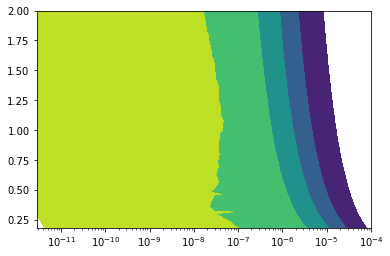

In [17]:
# create a mask then select the section of the dataframe we want to plot
biasing_mask = (
    (nch_data_df['VDS'] == 0.6) &
    (nch_data_df['VSB'] == 0.0) &
    (nch_data_df['GM_ID'] > 4)
    )

contour_df = nch_data_df[biasing_mask]

# I want to split the space by 5's
levels = np.linspace(5, 30, 6)

# plot the data
fig, axs = plt.subplots()

axs.tricontourf(contour_df['JD'],
    contour_df['L'],
    contour_df['GM_ID'],
    levels=levels
    )
axs.set_xscale('log')
fig.show()

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

/var/folders/k9/wmxxv63n3wv9x7jcl11w_v3h0000gn/T/ipykernel_93423/4174149772.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


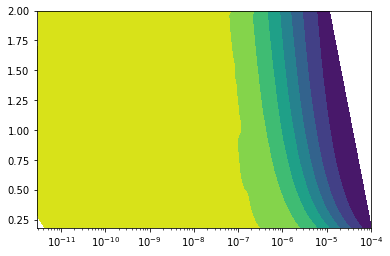

## Solution

Let's start by computing the current density:

In [ ]:
w = 5
i_d = 0.0008e-6
j_d = i_d / w
print(f"The desired current density is {j_d:.3e} A/um, or {j_d*1e9:.3f} nA/um")

Given that current density, we can plot intrinsic gain vs. current density
to find the $L$ that gives a gain of ~150 at 0.160 nA/um:

In [ ]:
cmap = linear_palette(Turbo256, nch_data_df['L'].nunique())
length_color_pairs = list(zip(nch_data_df['L'].unique(), cmap))
length_color_dict = dict(length_color_pairs)

TOOLTIPS = [
            ("x", "$x"),
            ("y", "$y"),
            ("L", "@L")
        ]

# create a figure
gain_plot = bh.create_bokeh_plot(
    title="Intrinsic gain vs. current density and L",
    x_axis_label="Id / W (A/um)",
    y_axis_label="Intrinsic gain",
    x_axis_type="log",
    tooltips=TOOLTIPS,
    width=800,
)

plot_mask = ((nch_data_df['VDS'] == 0.6) &
    (nch_data_df['VSB'] == 0.0))

for len, len_group in nch_data_df[plot_mask].groupby('L'):
    # display(len_group)
    data = ColumnDataSource(len_group)
    
    gain_plot.line(x='JD', y='GM_GDS', source=data, 
                       legend_label=f"l={len}", line_color=length_color_dict[len],
                       line_dash="solid")
        
# gain_plot.y_range = Range1d(1e8, 100e9)

# add vertical line for gmId = 15
gain_plot.add_layout(Span(location=j_d, dimension='height'))

# make the legend interactive
gain_plot.legend.click_policy = 'hide'

show(gain_plot)

From the plot above, we can see that a gate length of 1.5um gives us a gain of roughly 150
at the desired drain current of 0.8 nA.

To solve the rest of the problelm, we'll interpolate for the point where:
- L = 1.5 um
- JD (current density) = 1.6e-10 A/um
- $V_{ds}$ = 0.6 V
- $V_{bs}$ = 0 V

With those constraints, we get:

In [ ]:
# let's grab nch data that gives us jd of 1.6e-10 A/um,
# L = 1.5um,
# with V_ds=0.6 and V_sb=0.0

biasing_mask = (
    (nch_data_df['VDS'] == 0.6) &
    (nch_data_df['VSB'] == 0.0) &
    (nch_data_df['L'] == 1.5) &
    (nch_data_df['GM_ID'] > 2.5)
    )
# lookup_df = nch_data_df[lookup_mask].copy()
# use our interpolation function to get data with f_t of exactly 10 GHz
lookup_df = lookup(df=nch_data_df[biasing_mask], param='JD', target=1.6e-10).reset_index(drop=True)
display(
    lookup_df[['GM_GDS', 'GM_ID', 'GM_CGG', 'GM', 'VGS',]]
    )

The only thing the table doesn't give us is $f_u$, since we're not basing that off of a fanout spec.
Instead, we'll calculate that as $\frac{g_m}{C_L}$:

In [ ]:
c_l = 1e-12
f_u = lookup_df['GM'][0] / c_l
print(f"The unity gain frequency, f_u, is {f_u/1e3:0.2f} KHz")